<a href="https://colab.research.google.com/github/derek-byte/Keras-StableDiffusion/blob/main/Keras_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-cv tensorflow --upgrade

**Generating Images (Stable Diffusion)**

In [3]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [4]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
# Set back to the default for benchmarking purposes.
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(jit_compile=True)

198180272/198180272 [==============================] - 2s 0us/step


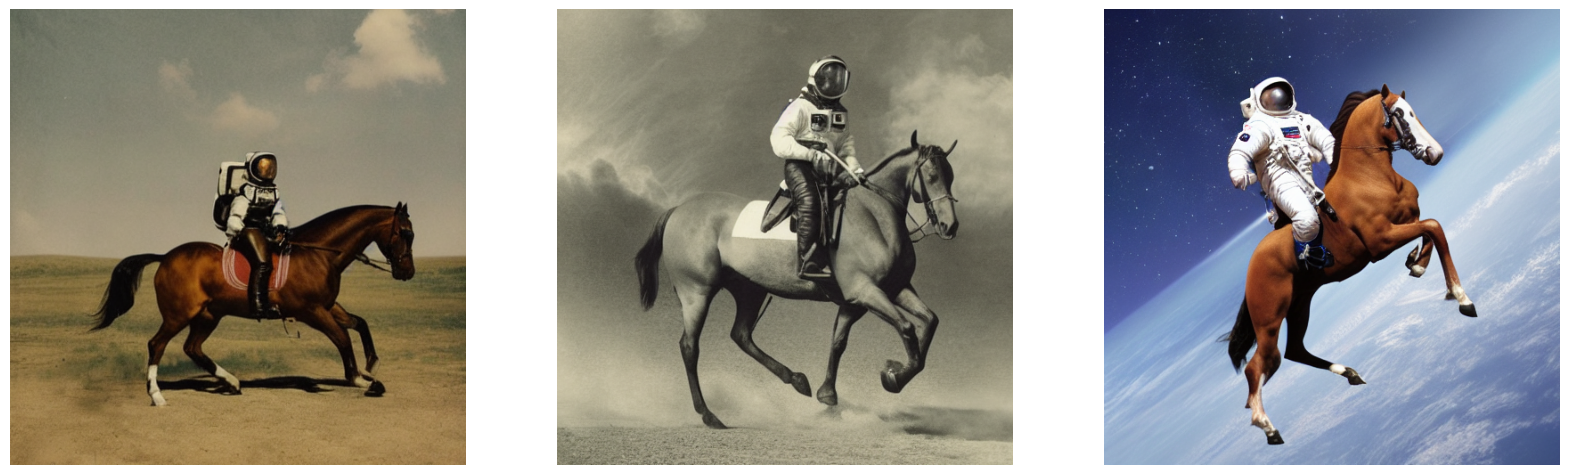

In [5]:
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

In [ ]:
images = model.text_to_image(
    "cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
plot_images(images)

 3/50 [>.............................] - ETA: 1:10:52

**QuickStart Keras**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
import tensorflow_datasets as tfds

# Create a preprocessing pipeline with augmentations
BATCH_SIZE = 16
NUM_CLASSES = 3
augmenter = keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(value_range=(0, 255)),
        keras_cv.layers.CutMix(),
    ]
)

def preprocess_data(images, labels, augment=False):
    labels = tf.one_hot(labels, NUM_CLASSES)
    inputs = {"images": images, "labels": labels}
    outputs = augmenter(inputs) if augment else inputs
    return outputs['images'], outputs['labels']

train_dataset, test_dataset = tfds.load(
    'rock_paper_scissors',
    as_supervised=True,
    split=['train', 'test'],
)
train_dataset = train_dataset.batch(BATCH_SIZE).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).map(
    preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
        tf.data.AUTOTUNE)

# Create a model using a pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet"
)
model = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=NUM_CLASSES,
    activation="softmax",
)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Train your model
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=8,
)

**Enhancing Images**

Enhanced Deep Residual Networks for single-image super-resolution - Gitesh Chawda

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/edsr.ipynb

**Generating Gifs (Keras CV and Stable Diffusion)**

In [ ]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

In [ ]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
interpolation_steps = 5

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

In [ ]:
seed = 12345
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

In [ ]:
from IPython.display import Image as IImage
IImage("doggo-and-fruit-5.gif")

In [ ]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

Walk-around Approach

In [ ]:
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size
step_size = 0.005

encoding = tf.squeeze(
    model.encode_text("The Eiffel Tower in the style of starry night")
)
# Note that (77, 768) is the shape of the text encoding.
delta = tf.ones_like(encoding) * step_size

walked_encodings = []
for step_index in range(walk_steps):
    walked_encodings.append(encoding)
    encoding += delta
walked_encodings = tf.stack(walked_encodings)
batched_encodings = tf.split(walked_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("eiffel-tower-starry-night.gif", images, rubber_band=True)

Looping Approach

In [ ]:
prompt = "An oil paintings of cows in a field next to a windmill in Holland"
encoding = tf.squeeze(model.encode_text(prompt))
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size

walk_noise_x = tf.random.normal(noise.shape, dtype=tf.float64)
walk_noise_y = tf.random.normal(noise.shape, dtype=tf.float64)

walk_scale_x = tf.cos(tf.linspace(0, 2, walk_steps) * math.pi)
walk_scale_y = tf.sin(tf.linspace(0, 2, walk_steps) * math.pi)
noise_x = tf.tensordot(walk_scale_x, walk_noise_x, axes=0)
noise_y = tf.tensordot(walk_scale_y, walk_noise_y, axes=0)
noise = tf.add(noise_x, noise_y)
batched_noise = tf.split(noise, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encoding,
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=batched_noise[batch],
        )
    ]

export_as_gif("cows.gif", images)